# CDF comparison of ERA5 and CMIP model outputs

**NOTE** this is an adaptation of the full climate change impact analysis (Hut, 2025), made so it works in this workshop.

By sorting the output in order of decreasing discharge, we can easily make a cummalative distribution. By taking the difference of these functions we derive a (very simple) bias correction function that can later be used to bias-correct the future model output when forced with CMIP projections.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [3]:
# For MEV
from scipy.stats import genextreme, gumbel_r, weibull_min

In [4]:
# Load settings
# Read from the JSON file
with open("settings.json", "r") as json_file:
    settings = json.load(json_file)

In [5]:
print(settings)

{
    'country': 'Zimbabwe',
    'caravan_id': 'AF_1491830.0',
    'calibration_start_date': '1961-10-01T00:00:00Z',
    'calibration_end_date': '1978-11-21T00:00:00Z',
    'future_start_date': '2029-08-01T00:00:00Z',
    'future_end_date': '2049-08-31T00:00:00Z',
    'base_path': '/home/mmelotto/my_data/workshop_africa',
    'central_data_path': '/data/shared/climate-data/camels_africa/zimbabwe/camel_data',
    'path_shape': 
'/data/shared/climate-data/camels_africa/zimbabwe/camel_data/shapefiles/AF_1491830/AF_1491830.shp',
    'path_caravan': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan',
    'path_ERA5': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/ERA5',
    'path_CMIP6': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/CMIP6',
    'path_output': '/home/mmelotto/my_data/workshop_africa/output_data/AF_1491830.0',
    'hbv_parameters': [10.0, 0.87, 592.0, 1.4, 0.3, 1.0, 0.09, 0.01, 0.001],
    'SCE_calibration_parameters': [
        6.586012553845907,
        1.0,
        557.8536779504233,
        2.939688843608312,
        0.001,
        1.0,
        0.1,
        0.00024827990873074545,
        3.2087728977063117
    ],
    'monte_carlo_calibration_parameters': [
        2.2809924457194377,
        0.8237298558744328,
        464.7470066408867,
        1.5984658697300798,
        0.29785129445020814,
        1.1825488171931156,
        0.07487754017358864,
        0.008908532718571173,
        5.605800944680686
    ]
}

In [6]:
# Open the output of the historic model and CMIP runs
historic_output = pd.read_pickle(Path(settings["path_CMIP6"])  / "historical" / "output.pkl")

# Load in the data again for the scenarios (note you can still load historical data here if you want)
SSP126_output = pd.read_pickle(Path(settings["path_CMIP6"])  / "SSP126" / "output.pkl")
SSP245_output = pd.read_pickle(Path(settings["path_CMIP6"])  / "SSP245" / "output.pkl")
SSP585_output = pd.read_pickle(Path(settings["path_CMIP6"])  / "SSP585" / "output.pkl")

In [7]:
print(historic_output)

1961-01-02 12:00:00    0.001241
1961-01-03 12:00:00    0.001718
1961-01-04 12:00:00    0.005851
1961-01-05 12:00:00    0.006161
1961-01-06 12:00:00    0.005822
                         ...   
1978-12-27 12:00:00    0.051865
1978-12-28 12:00:00    0.046741
1978-12-29 12:00:00    0.042129
1978-12-30 12:00:00    0.039667
1978-12-31 12:00:00    0.038883
Name: Historical, Length: 6573, dtype: float64

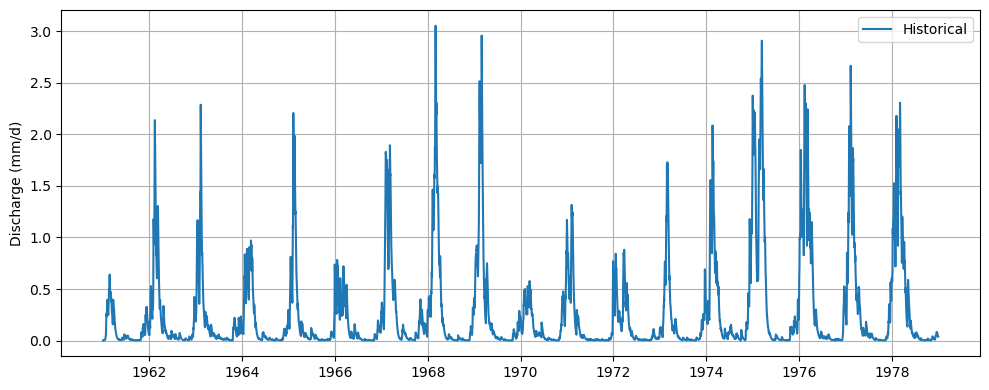

In [8]:
def plot_hydrograph(series):
    plt.figure(figsize=(10, 4))
    plt.plot(series.index, series.values, label=series.name)
    plt.ylabel("Discharge (mm/d)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# xr_one_year = xr_historic.sel(time=slice('2002-09-01', '2003-08-31'))

plot_hydrograph(historic_output)
# plot_hydrograph(xr_one_year)

In [9]:
def plot_cdf(data):
    """
    Plot CDF and return-period curves for a pandas Series or DataFrame.
    """

    # --- Convert Series → DataFrame ---
    if isinstance(data, pd.Series):
        df = data.to_frame()
    else:
        df = data

    # 1. Drop rows with missing data
    valid_df = df.dropna()

    # 2. Sort each column descending
    sorted_vars = {
        col: np.sort(valid_df[col].values)[::-1]
        for col in valid_df.columns
    }

    # 3. Create CDF index and return periods
    n = len(valid_df)
    cdf_index = np.linspace(0, 1, n)
    return_period_days = np.linspace(n, 1, n)
    return_period_years = return_period_days / 365.25

    # --- Plot CDFs ---
    plt.figure(figsize=(10, 6))
    for col in valid_df.columns:
        plt.plot(cdf_index, sorted_vars[col], label=col)

    plt.xlabel("Cumulative Probability")
    plt.ylabel("Discharge (mm/d)")
    plt.title("Empirical CDF")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Return Periods (log-log) ---
    plt.figure(figsize=(10, 6))
    for col in valid_df.columns:
        plt.plot(return_period_years, sorted_vars[col], label=col)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (mm/d)")
    plt.title("Return Period Plot")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

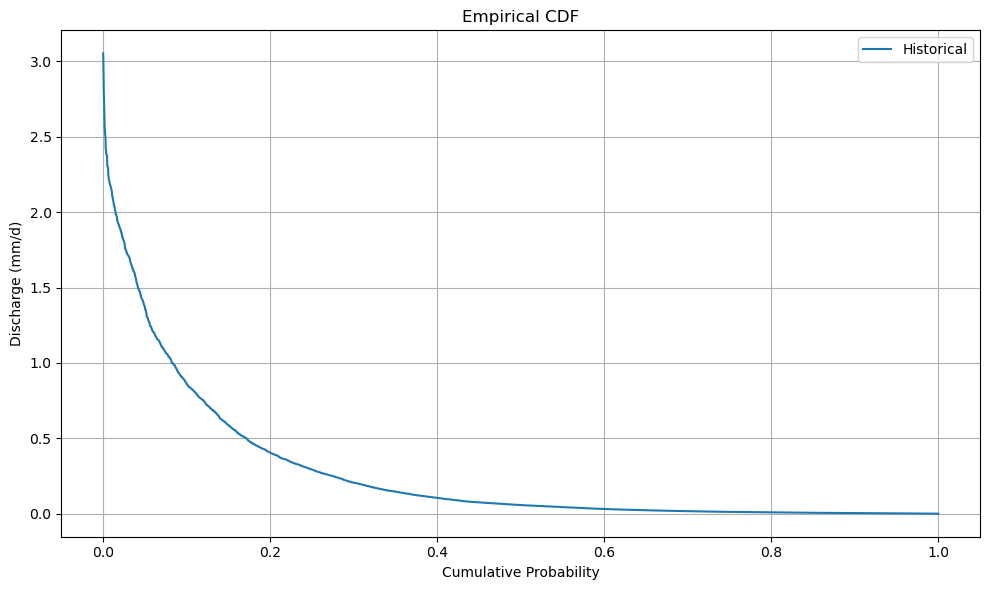

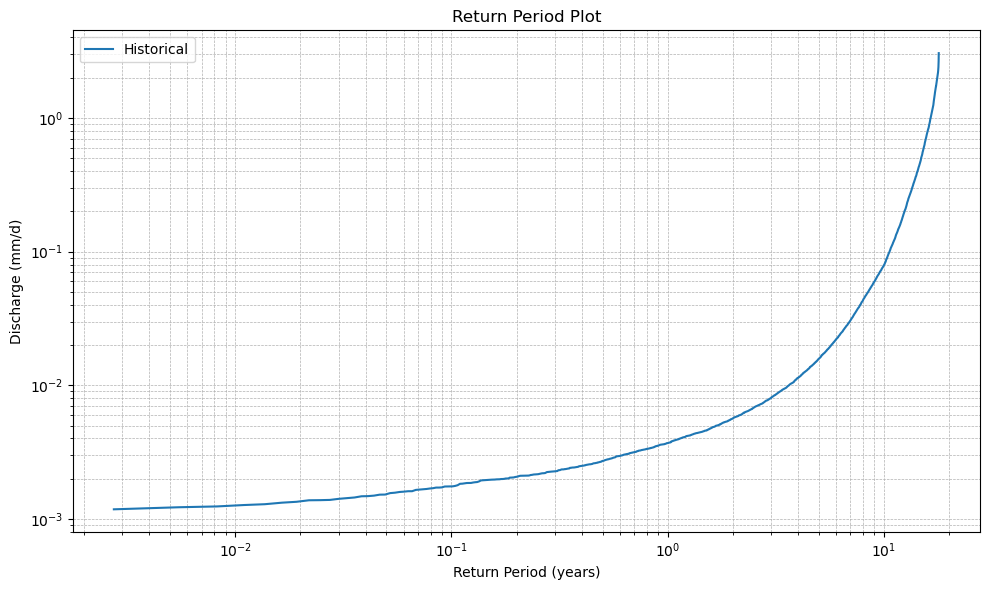

In [10]:
plot_cdf(historic_output)

In [11]:
def calculate_mev(data, dist_type='gev'):
    """
    Calculate MEV return periods for a pandas Series or DataFrame.

    Parameters
    ----------
    data : pd.Series or pd.DataFrame
        Daily discharge values with datetime index.
    dist_type : str
        One of ['gev', 'gumbel', 'weibull'].

    Returns
    -------
    dict
        {column_name: (x_values, return_period_values)}
    """

    # Convert Series → DataFrame
    if isinstance(data, pd.Series):
        df = data.to_frame()
    else:
        df = data.copy()

    # Drop missing days across all columns
    df = df.dropna()

    # Extract years from the datetime index
    years = df.index.year.unique()

    # Distribution selector
    if dist_type == 'gev':
        dist = genextreme
    elif dist_type == 'gumbel':
        dist = gumbel_r
    elif dist_type == 'weibull':
        dist = weibull_min
    else:
        raise ValueError("dist_type must be 'gev', 'gumbel', or 'weibull'")

    mev_results = {}

    # --- Process each column independently ---
    for col in df.columns:
        annual_params = []

        for yr in years:
            yearly_values = df.loc[df.index.year == yr, col].values
            if len(yearly_values) > 0:
                params = dist.fit(yearly_values)
                annual_params.append(params)

        # Build x-grid for CDFs
        x_vals = np.linspace(df[col].min(), df[col].max(), 1000)

        # Compute CDFs for each year's distribution
        cdfs = [dist.cdf(x_vals, *params) for params in annual_params]

        # MEV mean CDF
        mean_cdf = np.mean(cdfs, axis=0)

        # Return period
        return_period = 1 / (1 - mean_cdf)

        mev_results[col] = (x_vals, return_period)

    return mev_results


def plot_mev(*mev_dicts, dist_type='gev', labels=None):
    """
    Plot MEV curves from one or more MEV dictionaries.

    Parameters
    ----------
    mev_dicts : dicts
        Output of calculate_mev()
    dist_type : str
        Distribution type used
    labels : list of str
        Labels for each MEV dataset
    """

    plt.figure(figsize=(10, 6))

    for i, mev_res in enumerate(mev_dicts):
        prefix = f"{labels[i]} - " if labels else ""

        for var in mev_res:
            x_vals, rp_vals = mev_res[var]
            plt.plot(rp_vals, x_vals, label=f"{prefix}{var}")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (mm/d)")
    plt.title(f"MEV Estimates — {dist_type.upper()} Fit")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

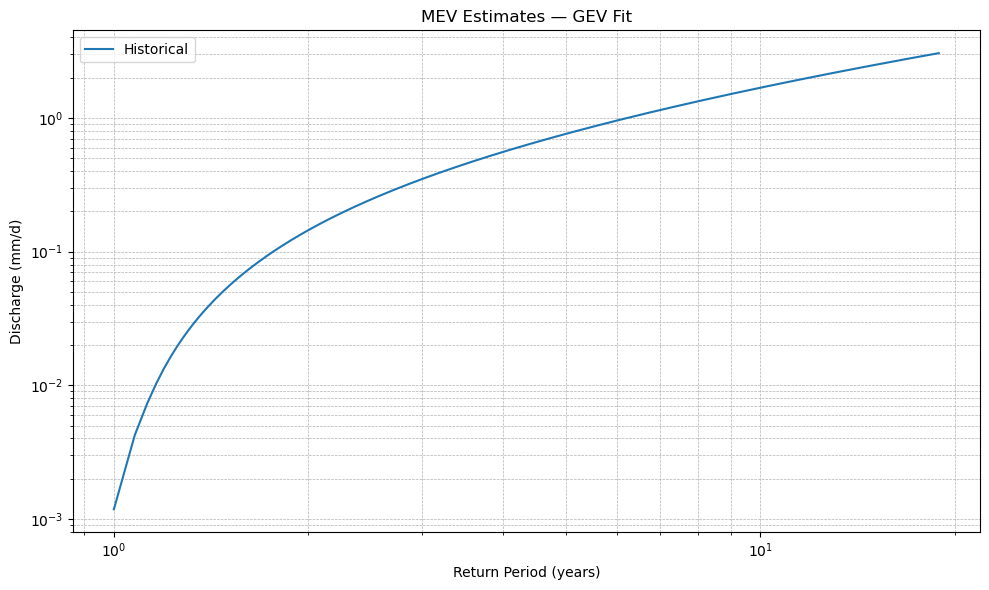

In [12]:
df_mev_historic = calculate_mev(historic_output,'weibull')
plot_mev(df_mev_historic)

In [13]:
# Open the output of the historic model and CMIP runs
df_future = pd.concat([SSP126_output, SSP245_output, SSP585_output], axis=1)

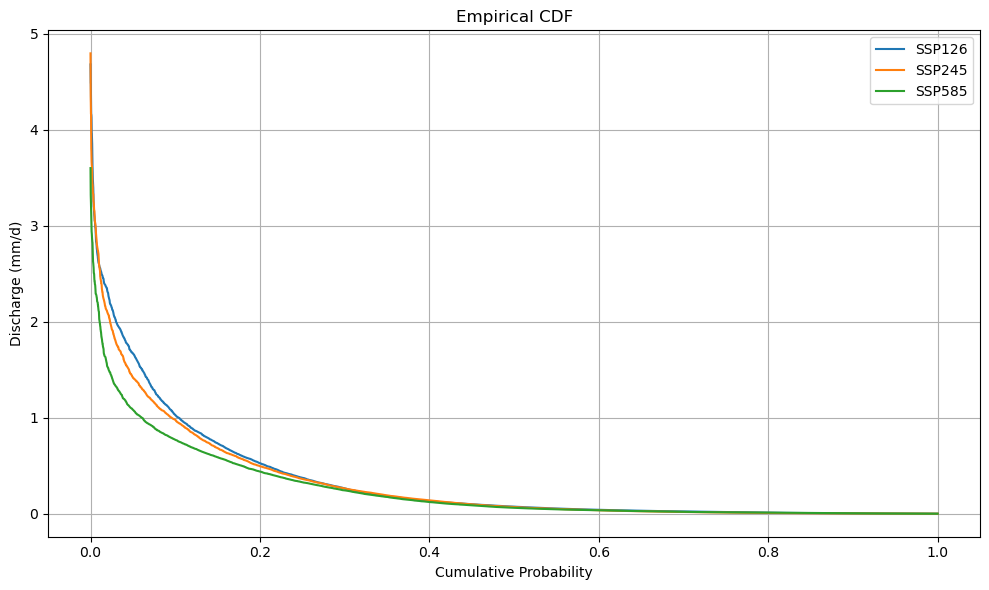

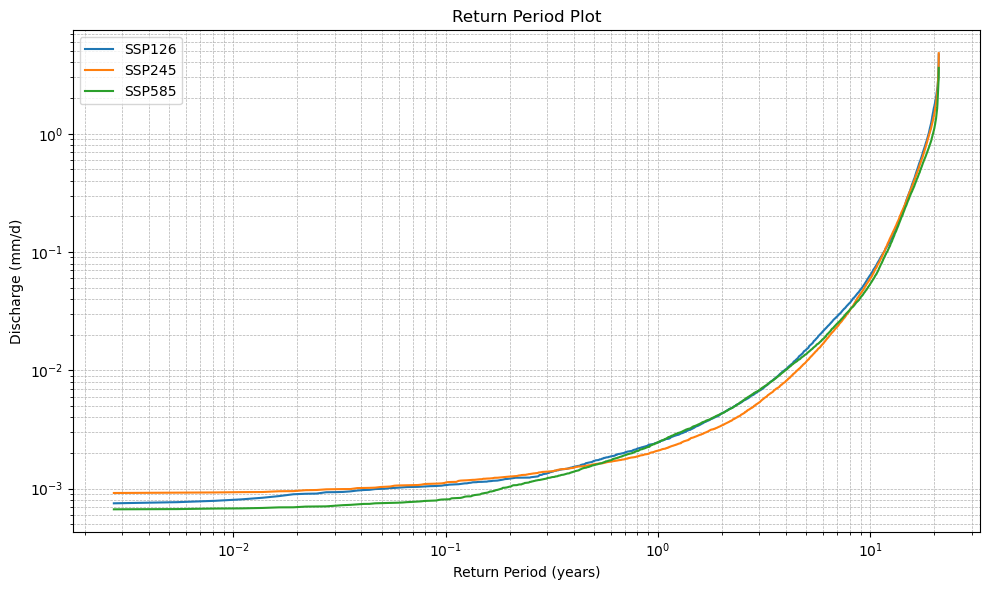

In [14]:
plot_cdf(df_future)

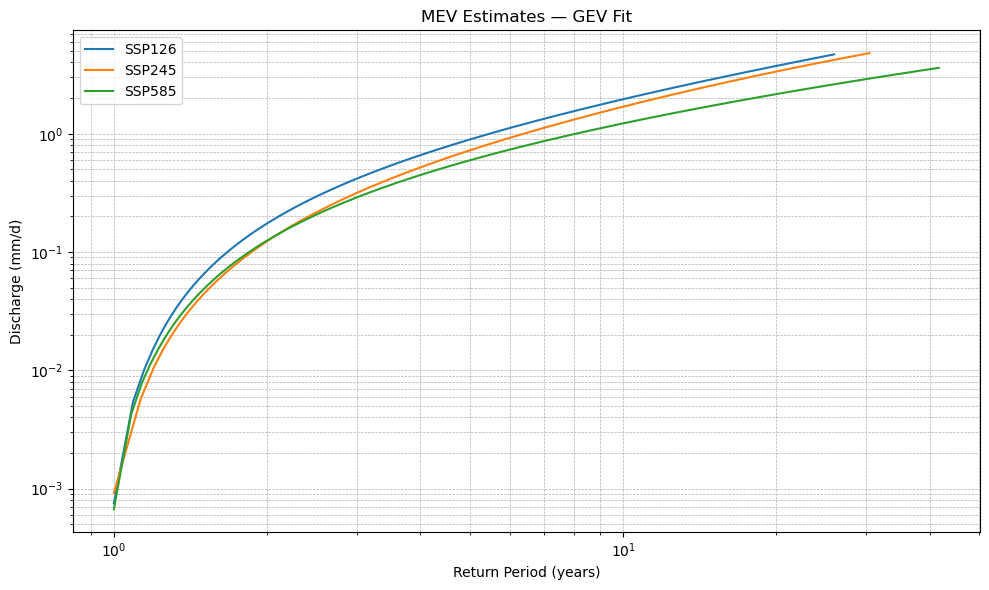

In [15]:
df_mev_future = calculate_mev(df_future,'weibull')
plot_mev(df_mev_future)

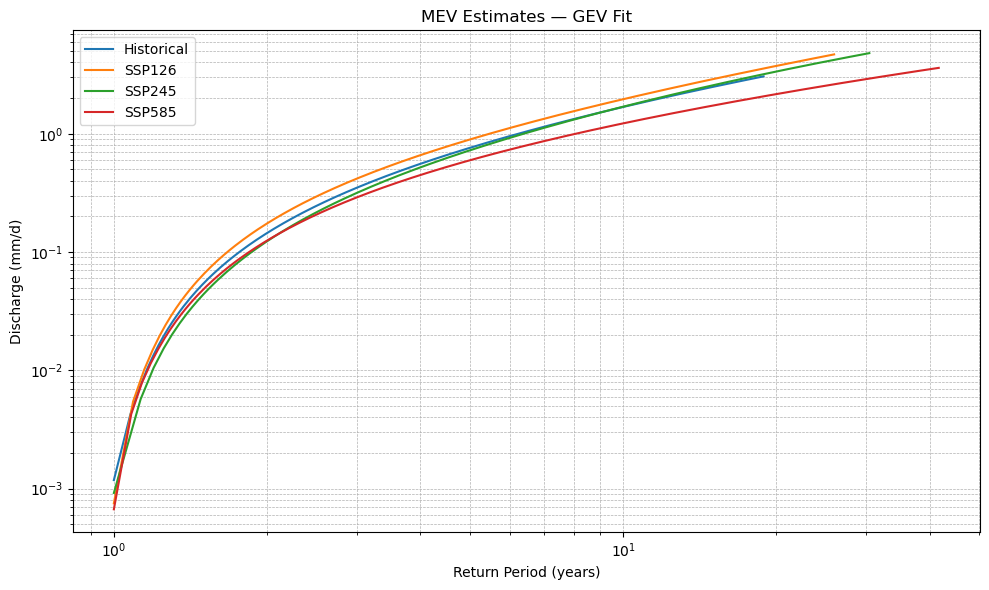

In [16]:
plot_mev(df_mev_historic, df_mev_future)